# bt backtesting (advanced)

- https://medium.com/@richardhwlin/advanced-backtesting-with-bt-635ed441cb60
- https://www.spglobal.com/spdji/en/indices/strategy/sp-500-sector-rotator-daily-rc2-6-index

In [131]:
# %pip install --upgrade numpy
# %pip install --upgrade pandas
# %pip install --upgrade matplotlib
# %pip install --upgrade yfinance
# %pip install --upgrade ffn
# %pip install --upgrade bt

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ffn
import bt
from datetime import timedelta
%matplotlib inline

## Load data

In [133]:
tickers = {
    'sp500': 'IVV',
    'cash': 'SHY',
    'sectors':['IYC','IDU','IYZ','IYW','IYJ','IYH','IYF','IYE','IYK','IYM','IYR']
}
all = [tickers['sp500'], tickers['cash']] + tickers['sectors']
df = yf.download(all, period='5y')['Adj Close']
df.head(3)

[*********************100%***********************]  13 of 13 completed


,IDU,IVV,IYC,IYE,IYF,IYH,IYJ,IYK,IYM,IYR,IYW,IYZ,SHY
Date,,,,,,,,,,,,,
2018-03-21,54.731155,249.965591,45.231152,30.629906,55.727951,166.831131,70.793655,107.419739,91.509689,64.999130,42.416599,24.809635,78.173706
2018-03-22,54.944363,243.668045,44.365925,30.002007,54.075813,161.924744,68.451088,105.852280,88.586426,64.622284,41.297817,24.328421,78.211205
2018-03-23,54.207336,238.491241,43.493675,29.830999,52.623989,158.595642,67.287125,104.333672,86.653473,63.592922,40.182178,23.864168,78.229935


In [134]:
class StatDrawdown(bt.Algo):
    def __init__(self, lookback=pd.DateOffset(months=3), lag=pd.DateOffset(days=0)):
        super(StatDrawdown, self).__init__()
        self.lookback = lookback
        self.lag = lag
    def __call__(self, target):
        selected = target.temp['selected']
        t0 = target.now - self.lag
        prc = target.universe.loc[(t0 - self.lookback):t0,selected]
        target.temp['stat'] = prc.to_drawdown_series().iloc[-1]
        # target.temp['stat'] = ffn.calc_sharpe(prc.pct_change().fillna(0))
        # target.temp['stat'] = ffn.calc_sortino_ratio(prc.pct_change().fillna(0))       
        return True

In [135]:
class StatInfoRatio(bt.Algo):
    def __init__(self, benchmark, lookback=pd.DateOffset(months=3), lag=pd.DateOffset(days=0)):
        super(StatInfoRatio, self).__init__()
        self.benchmark = benchmark
        self.lookback = lookback
        self.lag = lag
    def __call__(self, target):
        selected = target.temp['selected']
        t0 = target.now - self.lag
        prc = target.universe.loc[(t0 - self.lookback):t0,selected].pct_change().dropna()
        bmk = target.universe.loc[(t0 - self.lookback):t0,self.benchmark].pct_change().dropna()
        target.temp['stat'] = pd.Series({p:prc[p].calc_information_ratio(bmk) for p in prc})
        return True

In [136]:
# SP500 only
sp500 = bt.Strategy('SP500', algos = [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.SelectThese([tickers['sp500']]),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

In [137]:
# All sectors eqally weighted
spesw = bt.Strategy('SPESW', algos = [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.SelectThese(tickers['sectors']),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

In [138]:
# S&P High Momentum Value Strategy
sphmv = bt.Strategy('SPHMV', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.SelectThese(tickers['sectors']),
    StatDrawdown(lookback=pd.DateOffset(years=10)),
    # bt.algos.PrintTempData(),
    bt.algos.SelectN(5, sort_descending=False),
    # bt.algos.SelectN(5, sort_descending=True),
    StatInfoRatio(
        benchmark=tickers['sp500'],
        lookback=pd.DateOffset(months=7),
        lag=pd.DateOffset(months=1)
    ),
    bt.algos.SelectN(3, sort_descending=True), 
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

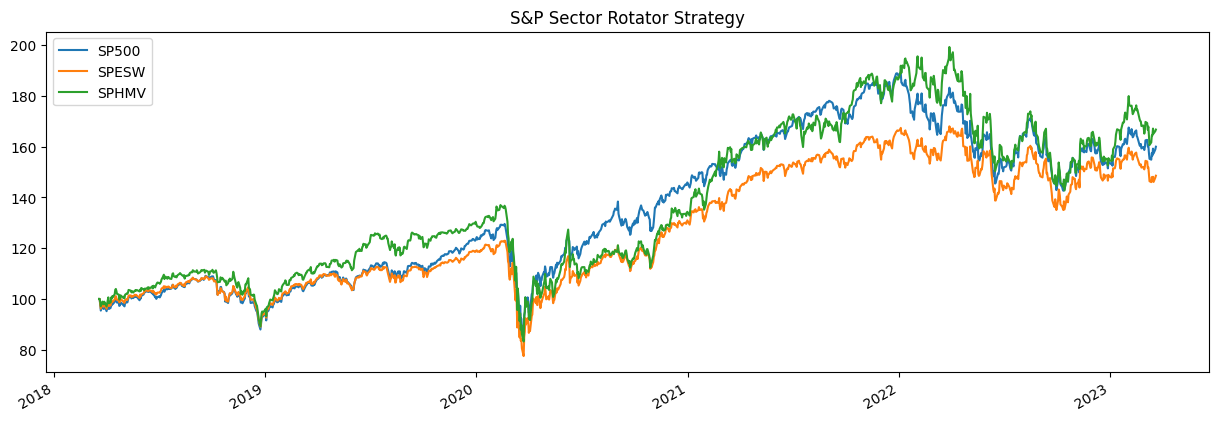

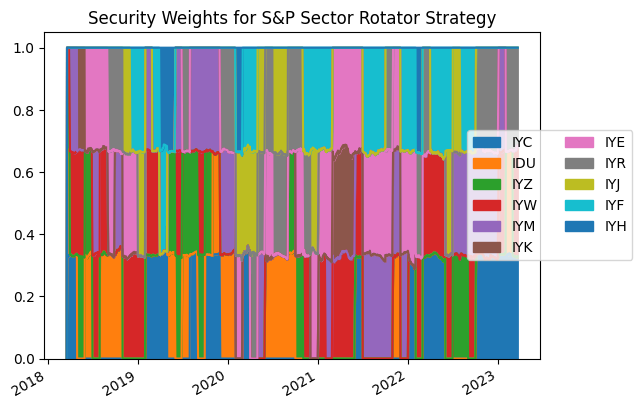

In [139]:
# run backtests
backtest_sp500 = bt.Backtest(sp500, df)
backtest_spesw = bt.Backtest(spesw, df)
backtest_sphmv = bt.Backtest(sphmv, df)
report = bt.run(backtest_sp500, backtest_spesw, backtest_sphmv)

# Plot performance
report.plot()
plt.title('S&P Sector Rotator Strategy')
plt.show()

# Plot Sector Weights
report.backtests['SPHMV'].security_weights.plot.area()
plt.title("Security Weights for S&P Sector Rotator Strategy")
plt.legend(ncol=2,loc='right', bbox_to_anchor=(1.2,0.5))
plt.show()

## Add Daily Volatility Control

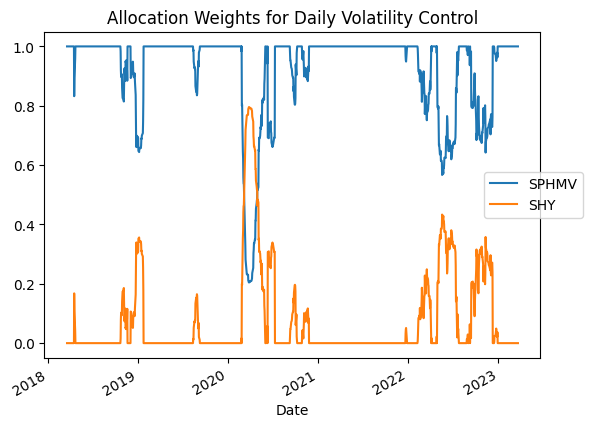

In [140]:
target_vol = 20
real_vol = df[tickers['sp500']].pct_change().rolling(20).std().multiply(np.sqrt(252)*100)
w = real_vol.map(lambda x: min(1, target_vol/x))
target_weight = pd.DataFrame({'SPHMV':w,'SHY':1-w})
target_weight.plot()
plt.title('Allocation Weights for Daily Volatility Control')
plt.legend(loc='right',bbox_to_anchor=(1.1,0.5))
plt.show()

c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python310\lib\site-packages\future\utils\__init

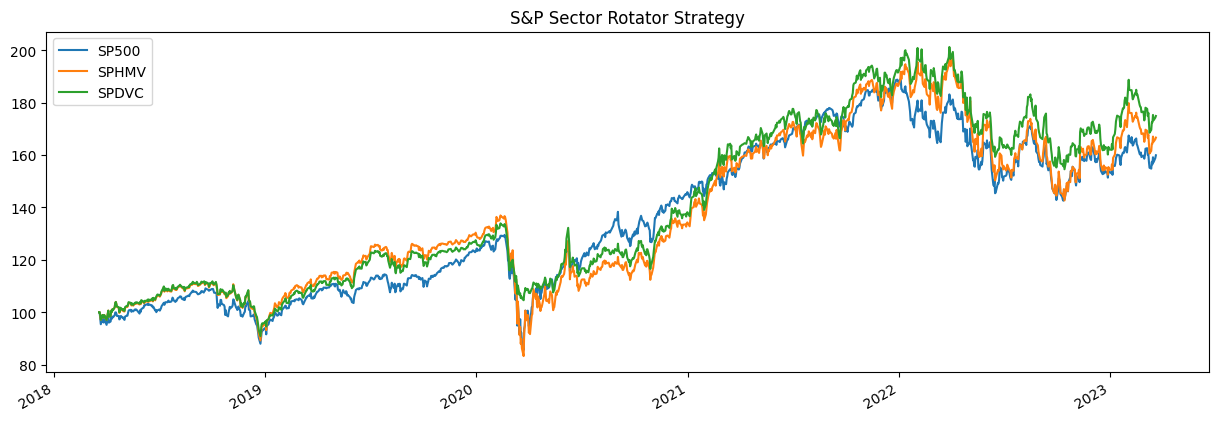

In [141]:
# daily volatility control
spdvc = bt.Strategy('SPDVC', [
    bt.algos.RunDaily(),
    # bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighTarget(target_weight),
    bt.algos.Rebalance()],
    children = [sphmv, tickers['cash']]
)
backtest_spdvc = bt.Backtest(spdvc, df)
report2 = bt.run(backtest_sp500, backtest_sphmv, backtest_spdvc)

# Plot performance
report2.plot()
plt.title('S&P Sector Rotator Strategy')
plt.show()

In [142]:
report2.display()

Stat                 SP500       SPHMV       SPDVC
-------------------  ----------  ----------  ----------
Start                2018-03-20  2018-03-20  2018-03-20
End                  2023-03-21  2023-03-21  2023-03-21
Risk-free rate       0.00%       0.00%       0.00%

Total Return         59.93%      66.68%      74.93%
Daily Sharpe         0.54        0.54        0.70
Daily Sortino        0.83        0.85        1.14
CAGR                 9.84%       10.75%      11.83%
Max Drawdown         -33.90%     -39.21%     -23.20%
Calmar Ratio         0.29        0.27        0.51

MTD                  0.46%       -0.41%      -0.41%
3m                   3.07%       6.82%       6.80%
6m                   5.96%       9.35%       7.97%
YTD                  4.06%       7.84%       7.84%
1Y                   -9.25%      -11.77%     -9.24%
3Y (ann.)            23.22%      26.10%      18.76%
5Y (ann.)            9.85%       10.76%      11.84%
10Y (ann.)           -           -           -
Since Incep. 